# Ajuste de las curvas obtenidas en el transitorio del circuito RCL Sub amortiguado

En este tutorial analizo los datos adquiridos de un circuito **RLC transitorio sub amortiguado**.

El circuito tiene las siguientes características:

```
 _____ -V0 (PULSE)+ _____ R _____ L _____ C ____   
|                     |               |         |  
GND                  Vin              VC        GND
```

Parámetros:
- R = 1 $k \Omega$
- L = 10 $m H$
- C = 1 $n F$

- Tiempo característico $\tau = 2L/R \approx 20$ usec
- $V_0$ tren de pulsos cuadrados, tension en alto $5V$. Periodo $T= 20 \tau \approx 400$ usec
- En $V_{in}$ se mide la señal de entrada respecto de GND (masa).
- En $V_C$ se mide la tensión en el capacitor respecto de GND (masa).

Empezamos importando las librerías necesarias:

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

Cargamos los datos:

<Axes: xlabel='time'>

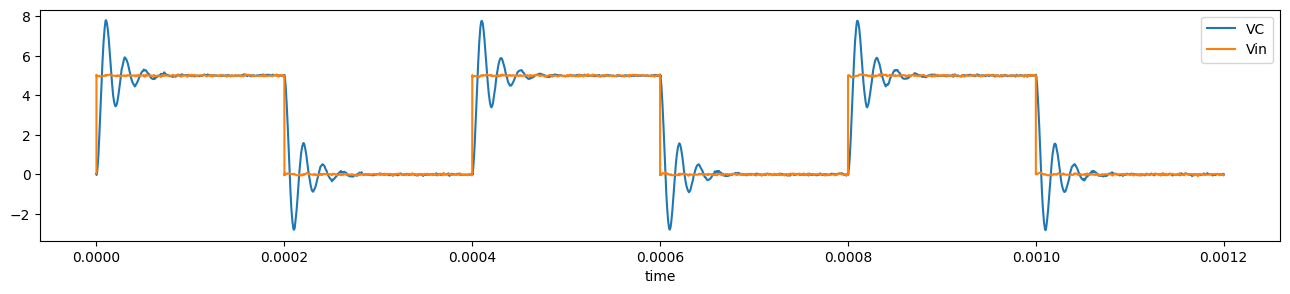

In [24]:
df = pd.read_csv("datos/data_RLC_sub.csv")

df.head()

df.plot( x='time', y=['VC','Vin'], figsize=(16,3) )

Paso el tiempo a microsegundos,

In [25]:
#df["time"]*=1e6

**Filtramos** los datos para quedarnos solo con uno de transitorios. Nos quedamos con el que esta entre los tiempos 0.04 y 0.06:

<Axes: xlabel='time'>

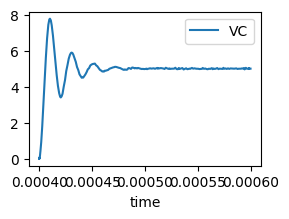

In [26]:
df_alto = df[ (df["time"]<600e-6) & (df["time"]>400e-6) ]

df_alto.plot(x='time', y='VC', figsize=(3,2))

El eje temporal esta trasladado, **llevamos el origen a cero** restando el primer punto, tambien pasamos nuestros datos a arrays de numpy para trabajar más cómodos el ajuste:

In [27]:
t0 = df_alto["time"].iloc[0]

t = df_alto["time"].to_numpy()-t0

VC = df_alto["VC"].to_numpy()

Definimos una **ecuación** para hacer el ajuste de la tensión que cae en los bornes del capacitor:

$$
V_C = V_0 \big( 1 - e^{-\gamma t} ( cos(\omega t) + \frac{\gamma}{\omega} sin(\omega t)   ) \big)
$$

In [28]:
def modelo_VC(u, V0, g, w):                         
    vc= V0*( 1- np.exp(-g*u)*( np.cos(w*u)+ (g/w)*np.sin(w*u) ) )    # Ec para la tensión VC caso sub amort
    return vc

Estimamos los valores de los parámeros para pasarselos al algoritmo como **semillas**:

In [29]:
R= 1000 + 50 +100
L= 10e-3
C= 1e-9

g = R/(2.0*L)
w02 = 1.0/(L*C)
w = np.sqrt(w02 - g**2 )

print (f"Amortiguamiento teórico: {g}")
print (f"Freq angular teórica: {w:.2f} 1/sec")


Amortiguamiento teórico: 57500.0
Freq angular teórica: 310956.19 1/sec


**Ajuste**:

In [30]:
# semillas
V0_ini = 5.0
g_ini  = 57000.0
w_ini  = 310000.0

# ajuste
popt, pcov = curve_fit(modelo_VC, t, VC, p0=[ V0_ini, g_ini, w_ini ] )      

# tomo parámetros
V0, g, w = popt

# Errores estandar
SE_V0, SE_g, SE_w = np.sqrt(np.diag(pcov))

print ("Parámetros obtenidos del ajuste:")
print(f"V0 = ({V0:.4f} ± {SE_V0:.4f})")
print(f"g  = ({g:.4f} ± {SE_g:.6f})")
print(f"w  = ({w:.4f} ± {SE_w:.6f})")

Parámetros obtenidos del ajuste:
V0 = (4.9973 ± 0.0017)
g  = (57101.2307 ± 183.120859)
w  = (307976.8377 ± 194.101739)


Hacemos un **plot** con los datos del experimento y el ajuste:

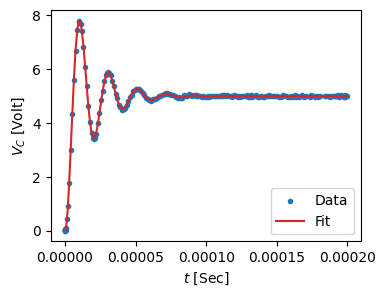

In [31]:
fig,ax = plt.subplots(figsize=(4,3))

ax.scatter( t, VC ,label='Data', marker='.')                         # datos

ax.plot( t, modelo_VC(t, V0, g, w), c='C3', label='Fit' )       # modelo con parametros del ajuste

ax.set_xlabel("$t$ [Sec]")
ax.set_ylabel("$V_C$ [Volt]")

plt.legend(loc=4)
plt.show()